In [ ]:
#Importing Libraries

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os


In [2]:
#Dataset Preparation

# Dataset paths
train_dir = "dataset/trainingData"  # Replace with your dataset's path
val_dir = "dataset/testingData"

# Image parameters
image_size = (224, 224)
batch_size = 32

# Data Augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 12845 images belonging to 27 classes.
Found 4268 images belonging to 27 classes.


In [3]:
# Load Pretrained VGG16 and Build the Model

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,144,411 (80.66 MB)

 Trainable params: 6,429,723 (24.53 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:


# Train the model
epochs = 10

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs)

# Save the trained model
model_save_path = "saved_vgg16_model.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


c:\Users\srvsh\anaconda3\envs\DS\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 1877s 5s/step - accuracy: 0.2806 - loss: 2.4891 - val_accuracy: 0.9473 - val_loss: 0.2833
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 1616s 4s/step - accuracy: 0.6339 - loss: 1.0398 - val_accuracy: 0.9941 - val_loss: 0.1127
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 1759s 4s/step - accuracy: 0.7055 - loss: 0.7951 - val_accuracy: 0.9944 - val_loss: 0.0645
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 2038s 5s/step - accuracy: 0.7384 - loss: 0.7004 - val_accuracy: 0.9986 - val_loss: 0.0459
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 2042s 5s/step - accuracy: 0.7492 - loss: 0.6741 - val_accuracy: 0.9974 - val_loss: 0.0410
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 1524s 4s/step - accuracy: 0.7598 - loss: 0.6300 - val_accuracy: 1.0000 - val_loss: 0.0182
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 1839s 5s/step - accuracy: 0.7597 - loss: 0.6200 - val_accuracy: 0.9988 - val_loss: 0.0155
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 2374s 6s/step - accuracy: 0.7694 - loss: 0.6133 - 

Model saved to saved_vgg16_model.h5


In [5]:
import pickle
history_save_path = "training_history.pkl"
with open(history_save_path, "wb") as f:
    pickle.dump(history.history, f)
print(f"Training history saved to {history_save_path}")

Training history saved to training_history.pkl


In [10]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

##print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy*100.0 :.2f}%")

# Print loss as well
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

##print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss * 100.0 :.2f}%")

Final Validation Accuracy: 99.98%
Final Validation Loss: 1.21%


In [12]:
# Save model architecture to JSON
model_json = model.to_json()
json_save_path = "vgg16_model_architecture.json"
with open(json_save_path, "w") as json_file:
    json_file.write(model_json)
print(f"Model architecture saved to {json_save_path}")

# Save model weights
weights_save_path = "vgg16_model_weights.weights.h5"
model.save_weights(weights_save_path)
print(f"Model weights saved to {weights_save_path}")


Model architecture saved to vgg16_model_architecture.json
Model weights saved to vgg16_model_weights.weights.h5


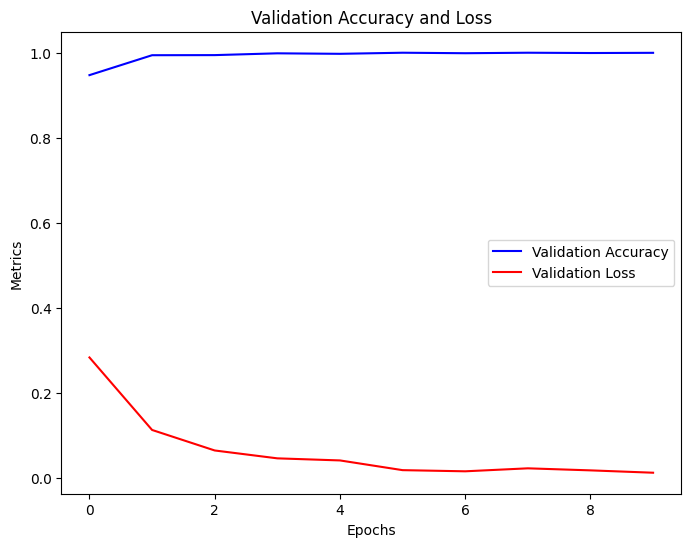

In [14]:
# Plot accuracy and loss

# Plot Training and Validation Accuracy and Loss
def plot_val_accuracy_and_loss(history):
    plt.figure(figsize=(8, 6))

    # Plot validation accuracy and validation loss
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

    plt.title('Validation Accuracy and Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

plot_val_accuracy_and_loss(history)


134/134 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step


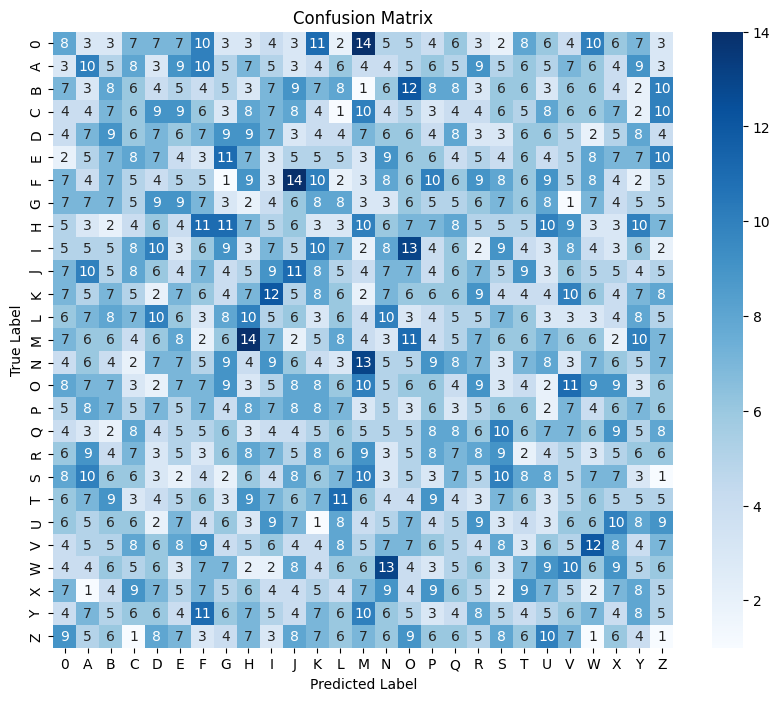

In [15]:
#Evaluate the Model with Confusion Matrix

# Predict on validation data
val_generator.reset()
predictions = model.predict(val_generator)
y_true = val_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(val_generator.class_indices.keys())

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [16]:
# Generate Classification report

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.05      0.05       154
           A       0.06      0.06      0.06       156
           B       0.05      0.05      0.05       157
           C       0.04      0.04      0.04       156
           D       0.05      0.05      0.05       155
           E       0.03      0.03      0.03       156
           F       0.03      0.03      0.03       165
           G       0.02      0.02      0.02       153
           H       0.04      0.04      0.04       165
           I       0.04      0.04      0.04       157
           J       0.07      0.07      0.07       166
           K       0.05      0.05      0.05       164
           L       0.04      0.04      0.04       155
           M       0.02      0.02      0.02       165
           N       0.03      0.03      0.03       163
           O       0.04      0.04      0.04       167
           P       0.04      0.04      0.04       155
   

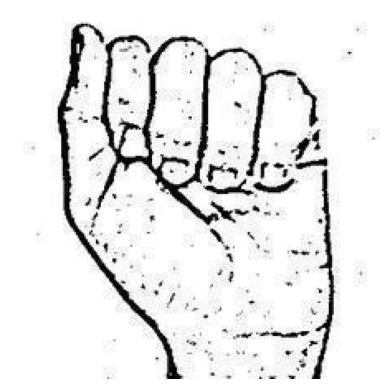

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Predicted Class: A


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define class labels (mapping indices to class names)
class_labels = [
    'blank',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]

# Load and preprocess the test image
img_path = 'C:\\Users\\srvsh\\Data_Science\\dataset\\testingData\\A\\3.jpg'  # Replace with your image path
test_image = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
plt.imshow(test_image)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Convert image to array and preprocess
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize to match training preprocessing

# Make prediction
result = model.predict(test_image)

# Get the class index with the highest probability
predicted_class_index = np.argmax(result, axis=1)[0]

# Map the predicted class index to the corresponding label
prediction = class_labels[predicted_class_index]

# Print the prediction
print(f"Predicted Class: {prediction}")


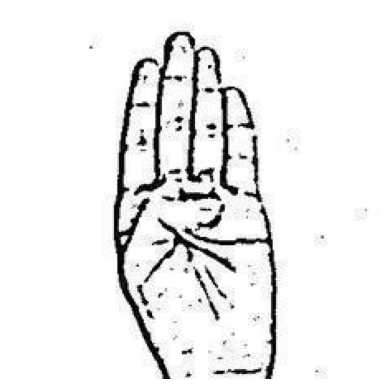

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicted Class: B


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define class labels (mapping indices to class names)
class_labels = [
    'blank',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]

# Load and preprocess the test image
img_path = 'C:\\Users\\srvsh\\Data_Science\\dataset\\testingData\\B\\3.jpg'  # Replace with your image path
test_image = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
plt.imshow(test_image)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Convert image to array and preprocess
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize to match training preprocessing

# Make prediction
result = model.predict(test_image)

# Get the class index with the highest probability
predicted_class_index = np.argmax(result, axis=1)[0]

# Map the predicted class index to the corresponding label
prediction = class_labels[predicted_class_index]

# Print the prediction
print(f"Predicted Class: {prediction}")


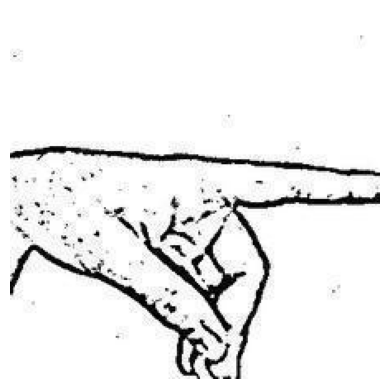

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Predicted Class: P


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define class labels (mapping indices to class names)
class_labels = [
    'blank',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]

# Load and preprocess the test image
img_path = 'C:\\Users\\srvsh\\Data_Science\\dataset\\testingData\\P\\3.jpg'  # Replace with your image path
test_image = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
plt.imshow(test_image)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Convert image to array and preprocess
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize to match training preprocessing

# Make prediction
result = model.predict(test_image)

# Get the class index with the highest probability
predicted_class_index = np.argmax(result, axis=1)[0]

# Map the predicted class index to the corresponding label
prediction = class_labels[predicted_class_index]

# Print the prediction
print(f"Predicted Class: {prediction}")


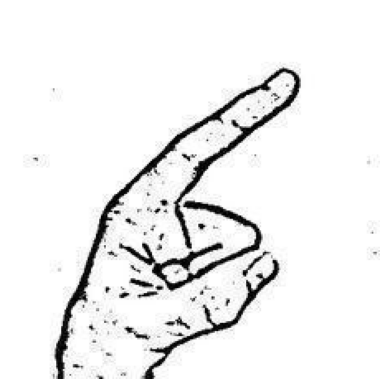

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Predicted Class: Z


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

model = tf.keras.models.load_model('saved_vgg16_model.h5')
# Define class labels (mapping indices to class names)
class_labels = [
    'blank',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]

# Load and preprocess the test image
img_path = 'C:\\Users\\srvsh\\Data_Science\\dataset\\testingData\\Z\\3.jpg'  # Replace with your image path
test_image = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
plt.imshow(test_image)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Convert image to array and preprocess
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize to match training preprocessing

# Make prediction
result = model.predict(test_image)

# Get the class index with the highest probability
predicted_class_index = np.argmax(result, axis=1)[0]

# Map the predicted class index to the corresponding label
prediction = class_labels[predicted_class_index]

# Print the prediction
print(f"Predicted Class: {prediction}")


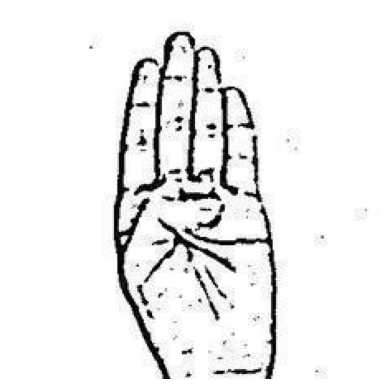

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
Predicted Class: B


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

model = tf.keras.models.load_model('saved_vgg16_model.h5')
# Define class labels (mapping indices to class names)
class_labels = [
    'blank',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z'
]

# Load and preprocess the test image
img_path = 'C:\\Users\\srvsh\\Data_Science\\dataset\\testingData\\B\\3.jpg'  # Replace with your image path
test_image = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
plt.imshow(test_image)  # Display the image
plt.axis('off')  # Hide axis
plt.show()

# Convert image to array and preprocess
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize to match training preprocessing

# Make prediction
result = model.predict(test_image)

# Get the class index with the highest probability
predicted_class_index = np.argmax(result, axis=1)[0]

# Map the predicted class index to the corresponding label
prediction = class_labels[predicted_class_index]

# Print the prediction
print(f"Predicted Class: {prediction}")
